In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt

import os
import json

In [28]:
paths = [
    os.path.join('..', 'command.out'),
    os.path.join('..', 'command.101932170.out'),
    os.path.join('..', 'command.114164404.out')
]

In [34]:
class FilterHelper():
    def __init__(self):
        self.cache = dict()
    
    def check(self, key):
        exists = self.cache.get(key, False)
        if not exists:
            self.cache[key] = True
        return exists

def uniqify(messages):
    helper = FilterHelper()
    return [m for m in messages if not helper.check(m['id'])]

def read_messages(paths):
    # Read All
    messages = []
    for path in paths:
        with open(path) as f:
            messages += json.loads(f.read())['messages']
    print("Read {} messages.".format(len(messages)))
    messages = uniqify(messages)
    print("{} unique messages.".format(len(messages)))
    return messages

messages = read_messages(paths)
len(messages)

Read 23670 messages.
23668 unique messages.


23668

In [91]:
alumni_bot_messages = [m for m in messages if 'alumni-bot' in m['sender_email']]
alumni_bot_ids = [m['id'] for m in alumni_bot_messages]
print(len(alumni_bot_messages))
print(alumni_bot_messages[-1])

1117
{'client': 'curl', 'sender_full_name': 'Alumni Bot', 'subject_links': [], 'sender_id': 8152, 'avatar_url': 'https://secure.gravatar.com/avatar/c2d3df6c859969f56dbdb7b39ab39319?d=identicon&version=1', 'id': 123857291, 'recipient_id': 41651, 'stream_id': 27333, 'sender_realm_str': 'recurse', 'sender_email': 'alumni-bot@students.hackerschool.com', 'sender_short_name': 'alumni-bot', 'flags': ['read'], 'content': 'Welcome to [checkins](https://gist.githubusercontent.com/mrdrozdov/bfd8d218a9414ce11b4d/raw/a23ff8cf560ef6fa60893bade9d05c5fc7f12313/alumin-checkins.txt)!', 'timestamp': 1521329401, 'content_type': 'text/x-markdown', 'reactions': [], 'type': 'stream', 'subject': 'Checkins! Sunday. March 18, 2018', 'is_me_message': False, 'display_recipient': 'alumni-checkins'}


In [94]:
user_messages = [m for m in messages if m['id'] not in alumni_bot_ids]

weekly_checkins = [m for m in user_messages if m['subject'].startswith('Checkins! Week')]
weekly_ids = set(m['id'] for m in weekly_checkins)
daily_checkins = [m for m in user_messages if m['subject'].startswith('Checkins!') and m['id'] not in weekly_ids]
daily_ids = set(m['id'] for m in daily_checkins)
periodic_ids = set.union(weekly_ids, daily_ids)
personal_checkins = [m for m in user_messages if m['id'] not in periodic_ids]

print(len(weekly_checkins), len(daily_checkins), len(personal_checkins))

149 17116 5286


In [104]:
weekly = [0]
daily = [0]
personal = [0]

for m in user_messages:
    w = weekly[-1]
    d = daily[-1]
    p = personal[-1]
    
    if m['subject'].startswith('Checkins! Week'):
        w = w + 1
    elif m['subject'].startswith('Checkins!'):
        d = d + 1
    else:
        p = p + 1
    
    weekly += [w]
    daily += [d]
    personal += [p]
    
len(weekly)
len(daily)
len(personal)

22552

<IPython.core.display.Javascript object>


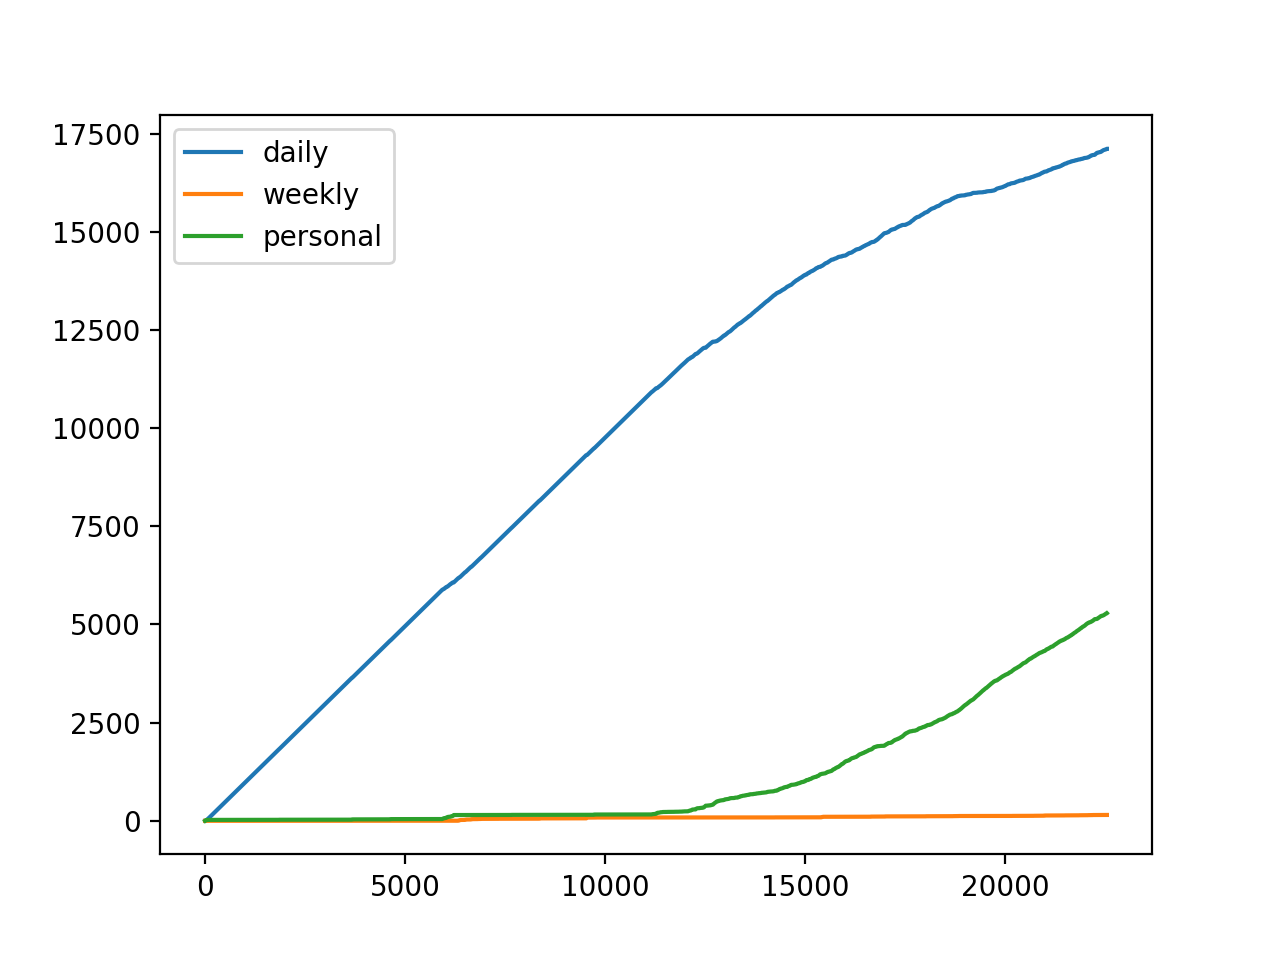

In [105]:
plt.figure()
plt.plot(range(len(daily)), daily, label='daily')
plt.plot(range(len(weekly)), weekly, label='weekly')
plt.plot(range(len(personal)), personal, label='personal')
plt.legend(loc='best')
plt.show()

In [115]:
n_last = len(user_m)
min_ts = user_messages[-n_last]['timestamp']
first_x = [0]

weekly_x = [0]
daily_x = [0]
personal_x = [0]

weekly_y = [0]
daily_y = [0]
personal_y = [0]

for m in user_messages[-n_last:]:
    w = weekly_y[-1]
    d = daily_y[-1]
    p = personal_y[-1]
    ts = m['timestamp'] - min_ts
    
    if m['subject'].startswith('Checkins! Week'):
        w = w + 1
    elif m['subject'].startswith('Checkins!'):
        d = d + 1
    else:
        p = p + 1
        
    weekly_x += [ts]
    daily_x += [ts]
    personal_x += [ts]
    
    weekly_y += [w]
    daily_y += [d]
    personal_y += [p]

<IPython.core.display.Javascript object>


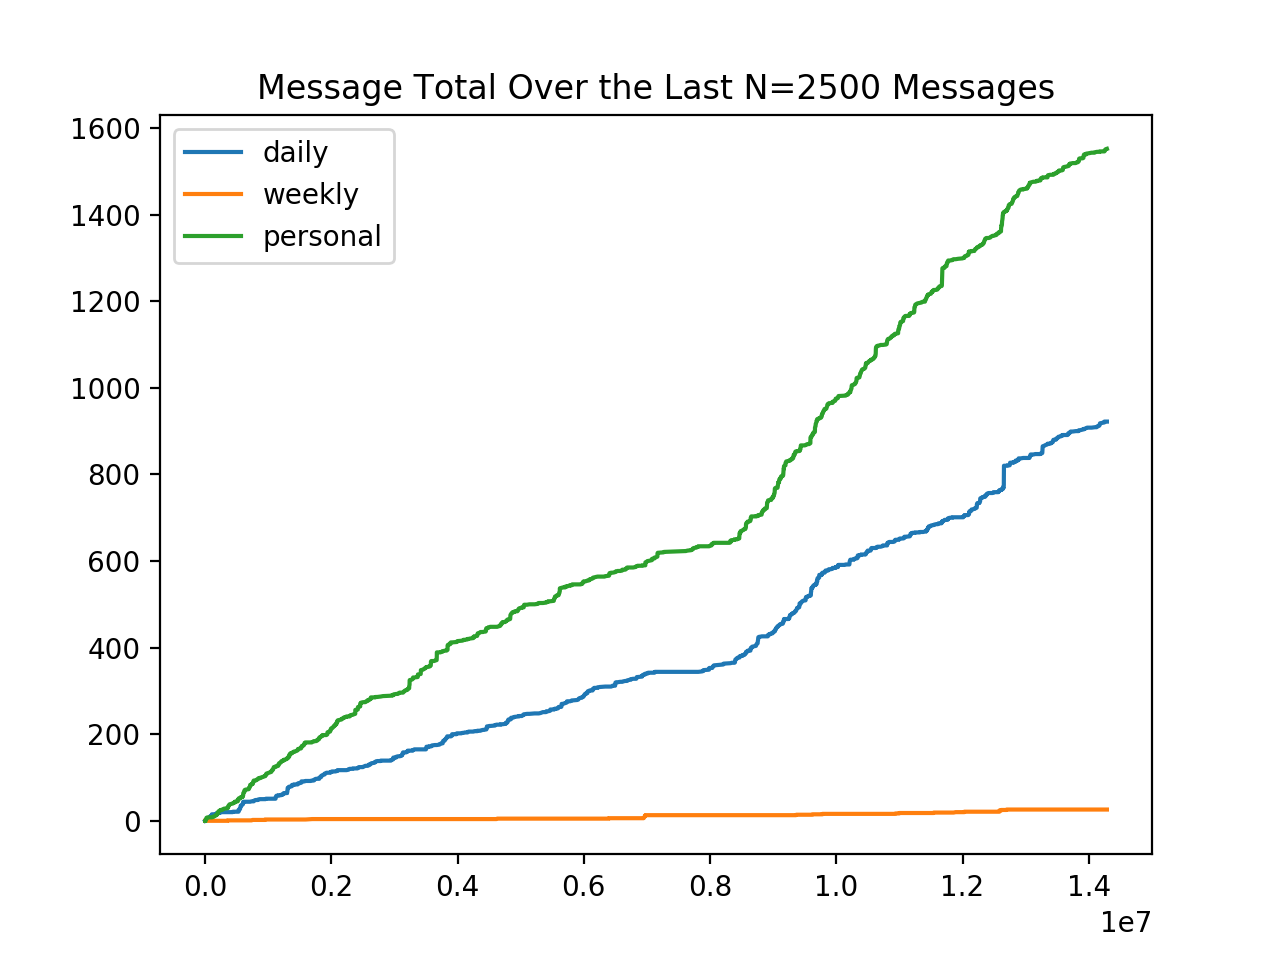

In [116]:
plt.figure()
plt.title('Message Total Over the Last N={} Messages'.format(n_last))
plt.plot(daily_x, daily_y, label='daily')
plt.plot(weekly_x, weekly_y, label='weekly')
plt.plot(personal_x, personal_y, label='personal')
plt.legend(loc='best')
plt.show()